In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sgkit as sg
import json
import hashlib
import itertools as it
import plotly.express as px
from IPython.display import Image
import xarray
import dask
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import zarr
import allel; print('scikit-allel', allel.__version__)
import os
from multiprocessing.pool import ThreadPool
dask.config.set(pool=ThreadPool(20))
from dask.diagnostics import ProgressBar
# quieten dask warnings about large chunks
dask.config.set(**{'array.slicing.split_large_chunks': True})

scikit-allel 1.3.8


In [3]:
#px config
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

#palette
countrycols = {
'Afghanistan' : '#a6cee3',
'Pakistan' : '#1f78b4',
'India' : '#b2df8a',
'SaudiArabia' : '#33a02c',
'Ethiopia': '#fb9a99',
'Djibouti' : '#e31a1c',
'Sudan' : '#fdbf6f',
'Yemen' : '#ff7f00'}


analysis_popcols =  {'saudi_e': '#6a3d9a',
'saudi_r': '#cab2d6',
'india_m': '#a6cee3',
 'india_b': '#1f78b4',
 'afgh_pak': '#ff7f00',
 'djibouti': '#e31a1c',
 'ethiopia_n': '#33a02c',
 'ethiopia_so': '#b2df8a',
 'yemen': '#fdbf6f',
 'sudan': '#fb9a99'}


#load and filter metadata
#load and filter metadata
df_samples = pd.read_table('/home/dennist/lstm_data/cease/variant_metadata/cease.combined.metadata.20240703.txt')
df_samples = df_samples[df_samples['qc_pass'] == 1].sort_values('order').reset_index()


In [10]:
# Initialize an empty dictionary to store row indices for each level
pop_dict = {}

# Iterate through unique levels in the 'factor_column'
for pop in df_samples['analysis_pop'].unique():
    pop_dict[pop] = df_samples.index[df_samples['analysis_pop'] == pop].tolist()

# Remove dictionary entries with fewer than 5 values
pop_dict = {key: value for key, value in pop_dict.items() if len(value) >= 5}

#get all pops too
#pop_dict['all'] = df_samples.index.tolist()


In [9]:
def hash_params(*args, **kwargs):
    """Helper function to hash analysis parameters."""
    o = {
        'args': args,
        'kwargs': kwargs
    }
    s = json.dumps(o, sort_keys=True).encode()
    h = hashlib.md5(s).hexdigest()
    return h

#function for getting allele counts
def snp_allele_counts(
    #gets all allele counts for a given chrom

        ds=None,
        sample_query=None,
        sample_list=None,
        min_ac=1
        ):
     
    if sample_query:
        loc_samples_a = df_samples.eval(sample_query).values
        ds = ds.isel(samples=loc_samples_a)
    elif sample_list:
        loc_samples_a = df_samples['sample_id'].isin(sample_list)
        ds = ds.isel(samples=loc_samples_a)

    ac = allel.GenotypeArray(ds.call_genotype.values).count_alleles()

    #need to make maf filter
    #if min_ac

    return ac

def do_fst_scan(
          chrom=None,
          sample_query_a=None, 
          sample_query_b=None,
          sample_list_a = None,
          sample_list_b=None,
          winsize=10000,
          analysis_name = 'fst',
          results_dir=None
    ):
            # construct a key to save the results under
    results_key = hash_params(
        chrom=chrom,
        sample_query_a=sample_query_a, 
        sample_query_b=sample_query_b,
        sample_list_a = sample_list_a,
        sample_list_b=sample_list_b, 
        winsize=winsize,
        analysis_name = analysis_name,
        results_dir=results_dir
        )

        # define paths for results files
    data_path = f'{results_dir}/{results_key}-fst.csv'

    try:
        # try to load previously generated results
        data = pd.read_csv(data_path)
        return data
    except FileNotFoundError:
        # no previous results available, need to run analysis
        print(f'running analysis: {results_key}')

    print('setting up inputs')

    #load ds
    ds = sg.load_dataset(f'/home/dennist/lstm_data/cease/variants_bycohort/combined_cohorts/zarr/combined_cohorts.{chrom}.zarr')

    #get allele counts for a
    if sample_query_a:
        ac1 = snp_allele_counts(ds, sample_query = sample_query_a)
    else:
        ac1 = snp_allele_counts(ds, sample_list = sample_list_a)

    #get ac for b
    if sample_query_a:
        ac2 = snp_allele_counts(ds, sample_query = sample_query_b)
    else:
        ac2 = snp_allele_counts(ds, sample_list = sample_list_b)
    
    #get pos
    pos = ds.variant_position.values

    print("allele counts and pos loaded")

    print("computing Fst")
    fst = allel.moving_hudson_fst(ac1, ac2, size=winsize)
    # Sometimes Fst can be very slightly below zero, clip for simplicity.
    fst = np.clip(fst, a_min=0, a_max=1)
    x = allel.moving_statistic(pos, statistic=np.mean, size=winsize)

    # save results
    fstdf = pd.DataFrame(
            {'chrom' : chrom,
            'midpos':x,
            'fst':fst})

    fstdf.to_csv(data_path, index=False)
    print(f'saved results: {results_key}')

    return(fstdf)



In [6]:
def do_fst_av(
          chrom=None,
          sample_query_a=None, 
          sample_query_b=None,
          sample_list_a = None,
          sample_list_b=None,
          winsize=10000,
          analysis_name = 'fst_average',
          results_dir=None
    ):
            # construct a key to save the results under
    results_key = hash_params(
        chrom=chrom,
        sample_query_a=sample_query_a, 
        sample_query_b=sample_query_b,
        sample_list_a = sample_list_a,
        sample_list_b=sample_list_b, 
        winsize=winsize,
        analysis_name = analysis_name,
        results_dir=results_dir
        )

        # define paths for results files
    data_path = f'{results_dir}/{results_key}-fst.csv'

    try:
        # try to load previously generated results
        data = pd.read_csv(data_path)
        return data
    except FileNotFoundError:
        # no previous results available, need to run analysis
        print(f'running analysis: {results_key}')

    print('setting up inputs')

    #load ds
    ds = sg.load_dataset(f'/home/dennist/lstm_data/cease/variants_bycohort/combined_cohorts/zarr/combined_cohorts.{chrom}.zarr')

    #get allele counts for a
    if sample_query_a:
        ac1 = snp_allele_counts(ds, sample_query = sample_query_a)
    else:
        ac1 = snp_allele_counts(ds, sample_list = sample_list_a)

    #get ac for b
    if sample_query_a:
        ac2 = snp_allele_counts(ds, sample_query = sample_query_b)
    else:
        ac2 = snp_allele_counts(ds, sample_list = sample_list_b)
    
    #get pos
    pos = ds.variant_position.values

    print("allele counts and pos loaded")

    print("computing average Hudson Fst")
    fst = allel.average_hudson_fst(ac1, ac2, blen=winsize)


    fdict = {'fst':fst[0],'se':fst[1]}
    fstdf = pd.DataFrame([fdict])

    fstdf.to_csv(data_path, index=False)
    print(f'saved results: {results_key}')

    return(fstdf)



In [5]:
#define shaded regions
# Define shaded region x values

#chr2
cyp6_start = 67473117
cyp6_end = 67501071

ace1_start = 60916071
ace1_end = 60917000



#chr3
vgsc_start = 42817709
vgsc_end = 42817800

gste_start = 70572788
gste_end = 70584603


#chrx
cyp9k1_start = 9721225
cyp9k1_end = 9722225



In [5]:
fstlist = []
winsize=10000
output = '/home/dennist/lstm_data/cease/analysis/fst_20240712/'

for chrom in ['CM023248','CM023249','CM023250']:
    for popa, popb in it.combinations(df_samples.analysis_pop.unique(),2):
        
        fst_df = do_fst_scan(
            chrom = chrom,
            sample_query_a = f'analysis_pop == "{popa}"',
            sample_query_b = f'analysis_pop == "{popb}"',
            results_dir = output,
            analysis_name=f'{chrom}.{winsize}.{popa}.{popb}'
        )

        fst_df['popa'] = popa
        fst_df['popb'] = popb

        fstlist.append(fst_df)

    
fst_bigdf  = pd.concat(fstlist)

fst_bigdf['comp'] = fst_bigdf['popa'] +'_' + fst_bigdf['popb']

from matplotlib.gridspec import GridSpec

max_values = fst_bigdf.groupby('chrom')['midpos'].max()
total_max = max_values.sum()
column_widths = (max_values / total_max).values
col_var_levels = max_values.index
    
cyp6_region = {'CM023248': {'x_min': 67473117, 'x_max': 67501071, 'y_min': 0, 'y_max': 1}}
ace1_region = {'CM023248': {'x_min': 60916071, 'x_max': 60917000, 'y_min': 0, 'y_max': 1}}
vgsc_region = {'CM023249': {'x_min': 42817709, 'x_max': 42817800, 'y_min': 0, 'y_max': 1}}
gste_region = {'CM023249': {'x_min': 70572788, 'x_max': 70584603, 'y_min': 0, 'y_max': 1}}
carboxylesterase_region = {'CM023249':{'x_min' : 18816120, 'x_max' :18816120, 'y_min': 0, 'y_max': 1}}
cyp9_region = {'CM023250': {'x_min': 9721225, 'x_max': 9722225, 'y_min': 0, 'y_max': 1}}
diagk = {'CM023250': {'x_min': 4578144, 'x_max': 4578144, 'y_min': 0, 'y_max': 1}}




NameError: name 'do_fst_scan' is not defined

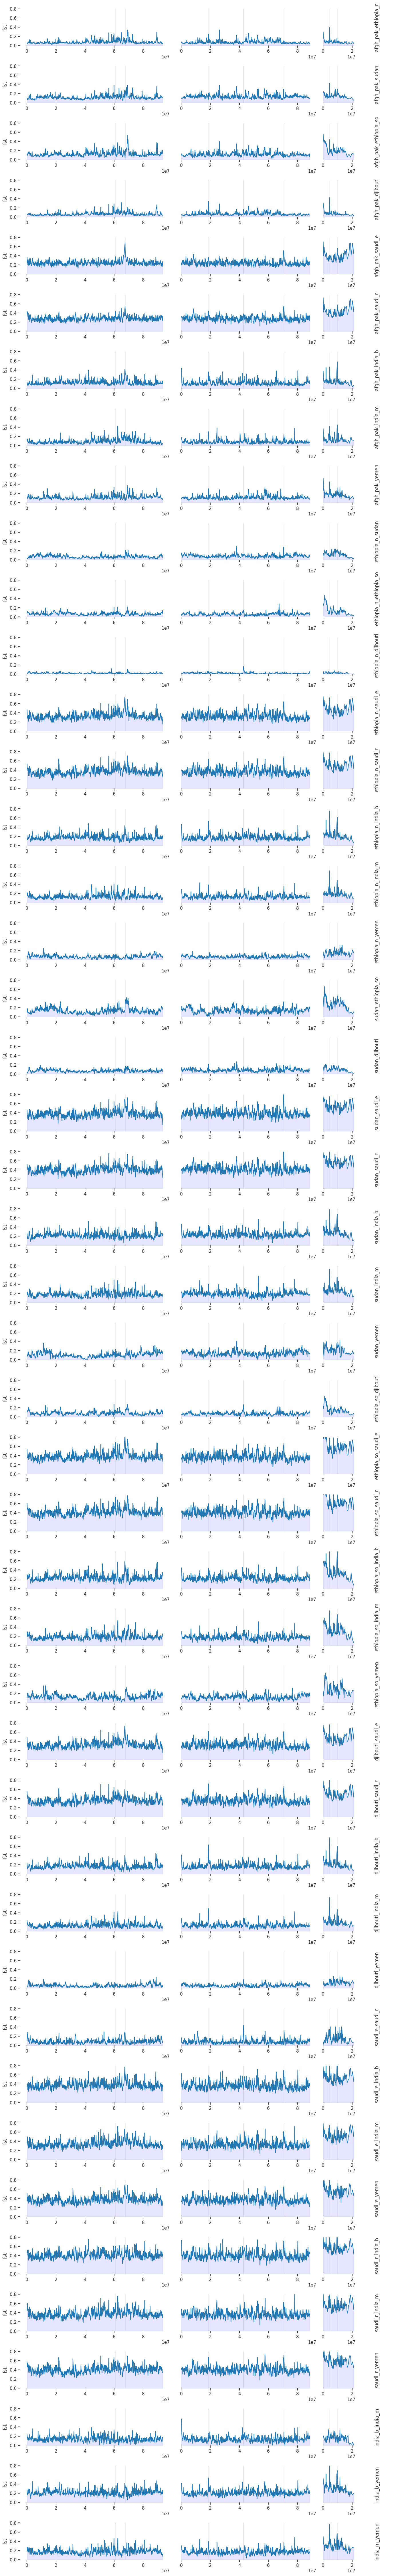

In [34]:
# Get the unique row and column variables
row_var_levels = fst_bigdf['comp'].unique()

# Initialize the figure and GridSpec
fig = plt.figure(figsize=(sum(column_widths) * 14, len(row_var_levels) * 2))  # Plots half as high
gs = GridSpec(len(row_var_levels), len(col_var_levels) + 1, width_ratios=list(column_widths) + [0.1])

# Create the subplots
for row_idx, row_val in enumerate(row_var_levels):
    for col_idx, col_val in enumerate(col_var_levels):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        subset = fst_bigdf[(fst_bigdf['comp'] == row_val) & (fst_bigdf['chrom'] == col_val)]
        sns.lineplot(data=subset, x='midpos', y='fst', ax=ax)

        ax.fill_between(x=subset['midpos'], y1=subset['fst'], color='blue', alpha=0.1)  # Adjust alpha for transparency if needed

        #ax.set_title(f"{row_val} - {col_val}")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # Remove y-axis for 2nd and 3rd columns
        if col_idx > 0:
            ax.set_ylabel('')
            ax.yaxis.set_visible(False)

        if col_val == 'CM023248':
            ax.fill_betweenx([cyp6_region[col_val]['y_min'], cyp6_region[col_val]['y_max']],
                            cyp6_region[col_val]['x_min'], cyp6_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
            ax.fill_betweenx([ace1_region[col_val]['y_min'], ace1_region[col_val]['y_max']],
                            ace1_region[col_val]['x_min'], ace1_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
        elif col_val == 'CM023249':
            ax.fill_betweenx([vgsc_region[col_val]['y_min'], vgsc_region[col_val]['y_max']],
                            vgsc_region[col_val]['x_min'], vgsc_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
            ax.fill_betweenx([gste_region[col_val]['y_min'], gste_region[col_val]['y_max']],
                            gste_region[col_val]['x_min'], gste_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
            ax.fill_betweenx([carboxylesterase_region[col_val]['y_min'], carboxylesterase_region[col_val]['y_max']],
                            carboxylesterase_region[col_val]['x_min'], carboxylesterase_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
        elif col_val == 'CM023250':
            ax.fill_betweenx([cyp9_region[col_val]['y_min'], cyp9_region[col_val]['y_max']],
                            cyp9_region[col_val]['x_min'], cyp9_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
            ax.fill_betweenx([diagk[col_val]['y_min'], diagk[col_val]['y_max']],
                            diagk[col_val]['x_min'], diagk[col_val]['x_max'],
                            color='gray', alpha=0.3)

        

        # Remove x-axis
        ax.set_xlabel('')
        #ax.xaxis.set_visible(False)

        ax.set_ylim(0, 0.8)

        
    # Add the row title
    row_ax = fig.add_subplot(gs[row_idx, -1])
    row_ax.text(0.5, 0.5, row_val, va='center', ha='center', fontsize=12, rotation=90, transform=row_ax.transAxes)
    row_ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)  # Reduce column and row padding
plt.tight_layout()
plt.show()


In [11]:
fstlist = []
winsize=10000
output = '/home/dennist/lstm_data/cease/analysis/fst_20240712/'

for chrom in ['CM023248','CM023249','CM023250']:
    for popa, popb in it.combinations(df_samples.analysis_pop.unique(),2):
        
        hud_fst_df = do_fst_av(
            chrom = chrom,
            sample_query_a = f'analysis_pop == "{popa}"',
            sample_query_b = f'analysis_pop == "{popb}"',
            results_dir = output,
            #analysis_name=f'{chrom}.{winsize}.{popa}.{popb}.hudfst'
        )

        hud_fst_df['popa'] = popa
        hud_fst_df['popb'] = popb
        hud_fst_df['chrom'] = chrom

        fstlist.append(hud_fst_df)

In [12]:
fst_hud_df = pd.concat(fstlist)

In [13]:
sub = fst_hud_df[fst_hud_df['chrom'] == 'CM023248']

In [14]:
sub2 = sub.copy()
sub2

,fst,se,popa,popb,chrom
0,0.076351,0.001394,afgh_pak,ethiopia_n,CM023248
0,0.119555,0.001526,afgh_pak,sudan,CM023248
0,0.127793,0.001896,afgh_pak,ethiopia_so,CM023248
0,0.066396,0.001351,afgh_pak,djibouti,CM023248
0,0.248881,0.001824,afgh_pak,saudi_e,CM023248
0,0.278724,0.001712,afgh_pak,saudi_r,CM023248
0,0.126813,0.001731,afgh_pak,india_b,CM023248
0,0.088884,0.001755,afgh_pak,india_m,CM023248
0,0.117907,0.001561,afgh_pak,yemen,CM023248
0,0.071055,0.001013,ethiopia_n,sudan,CM023248


In [28]:
order = list(analysis_popcols.keys())
order.reverse()


['sudan',
 'yemen',
 'ethiopia_so',
 'ethiopia_n',
 'djibouti',
 'afgh_pak',
 'india_b',
 'india_m',
 'saudi_r',
 'saudi_e']

Text(65.04687499999999, 0.5, 'Population B')

<Figure size 800x600 with 0 Axes>

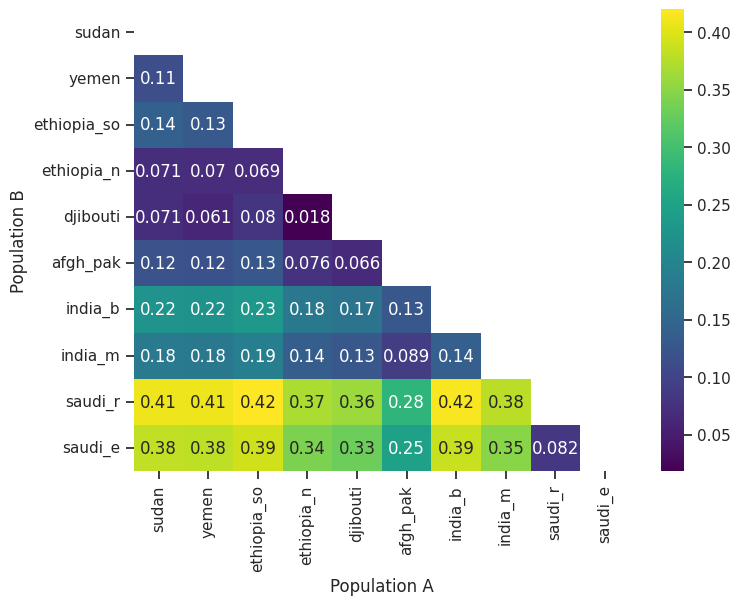

In [29]:
sub2.columns = ['fst', 'se', 'popb', 'popa', 'chrom']
subc=pd.concat([sub,sub2])
pivot_df = subc.pivot(index="popa", columns="popb", values="fst")

#reorder df

reordered_df = pivot_df.loc[order, order]

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(reordered_df, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    reordered_df,
    mask=mask,
    cmap='viridis',  # Use viridis color palette
    annot=True,
    cbar=True
)

# Customize axis labels
ax.set_xlabel('Population A')
ax.set_ylabel('Population B')

In [23]:
pivot_df = subc.pivot(index="popa", columns="popb", values="fst")

# Fill missing values in the upper triangle with values from the lower triangle
pivot_df = pivot_df.fillna(0)

# Convert to numpy array for easier manipulation
matrix = pivot_df.values

# Create a symmetric matrix by mirroring the lower triangle to the upper triangle
symmetric_matrix = np.maximum(matrix, matrix.T)

# Convert back to DataFrame
symmetric_df = pd.DataFrame(symmetric_matrix, index=pivot_df.index, columns=pivot_df.columns)



In [27]:
np.maximum(matrix, matrix.T)

array([[0.06639564, 0.07635087, 0.12779266, 0.12681266, 0.08888418,
        0.24888088, 0.27872431, 0.1195549 , 0.11790671],
       [0.07635087, 0.        , 0.        , 0.17059177, 0.12666916,
        0.32948922, 0.35887418, 0.        , 0.0611736 ],
       [0.12779266, 0.        , 0.06927841, 0.17953113, 0.13643046,
        0.33997864, 0.36917104, 0.07105543, 0.139285  ],
       [0.12681266, 0.17059177, 0.17953113, 0.23066081, 0.18816552,
        0.39076086, 0.41999025, 0.4156295 , 0.2245582 ],
       [0.08888418, 0.12666916, 0.13643046, 0.18816552, 0.1388104 ,
        0.        , 0.34896913, 0.37834698, 0.2223009 ],
       [0.24888088, 0.32948922, 0.33997864, 0.39076086, 0.        ,
        0.        , 0.        , 0.        , 0.38149471],
       [0.27872431, 0.35887418, 0.36917104, 0.41999025, 0.34896913,
        0.        , 0.08197202, 0.        , 0.41048411],
       [0.1195549 , 0.        , 0.07105543, 0.4156295 , 0.37834698,
        0.        , 0.        , 0.        , 0.4096078 ],
